In [1]:
# coding:utf-8
import numpy as np
import json
import os
import jieba
import jieba.analyse
import re
from snownlp import SnowNLP

In [2]:
##parameter
data_place = r".\original-microblog"

##hyper-parameter
top_word = 20##分词超参数
allowpos = ('ns', 'n', 'vn', 'v','a','e','d','o','r')##关键词属性设置

In [3]:
##feature
##content feature
corpus = []##语料库
exclamation_mark = []##感叹号个数
question_mark = []##问号个数
postive_words = []##褒义词个数
negative_words = []##贬义词个数
positive_rate = []##这条微博的积极性

In [4]:
##weibo feature
has_url = []##微博当中是否含有超链接
##user feature
description = []##原始微博发布者是否有描述
gender = []##原始微博发布者性别
followers = []##原始微博发布者被关注量
friends = []##原始微博发布者朋友数
verified = []##用户是否认证
##label
category = []##类别

In [5]:
##共3300个数据，1451个谣言
def read_data(path):
    global corpus
    global gender
    global followers
    global friends
    global verified
    global description
    global has_url
    global category
    path_list = os.listdir(path)
    for filename in path_list:
        if os.path.splitext(filename)[1] == '.json':
            with open(path + "\\" + filename, encoding='utf-8') as fp:
                data = json.load(fp)
                if(data['user'] == 'empty'):
                    continue
                corpus.append(re.sub(r'[^\u4E00-\u9FA5?？!！]',"",data['text']))
                description.append(data['user']['description'])
                gender.append(data['user']['gender'])
                followers.append(data['user']['followers'])
                friends.append(data['user']['friends'])
                has_url.append(data['has_url'])
                verified.append(data['user']['verified'])
                if(int(re.match("\d+",filename).group()) <= 2600):
                    category.append(1)
                if(int(re.match("\d+",filename).group()) > 2600):
                    category.append(0)

    has_url = np.array(has_url).astype(int)
    verified = np.array(verified).astype(int)
    description = np.array(description).astype(int)
    gender = np.array(list(map(trans_gender, gender)))
    followers = np.array(followers)
    friends = np.array(friends)
    category = np.array(category)

In [6]:
def trans_gender(gender):
    if(gender == "m"):
        return 1
    else:
        return 0
##统计感叹号与问号的个数
def count_punction():
    global exclamation_mark
    global question_mark
    exclamation_mark = np.array([i.count('！') + i.count('!') for i in corpus])
    question_mark = np.array([i.count('？') + i.count('?') for i in corpus])

In [7]:
##acquire text features
##处理原始微博的褒贬属性(统计褒贬词的个数[根据词的情感态度]，分析一条微博的积极性，算法为——
##将一条微博的前top_word个关键词找出，其排序的方式为TF-IDF，TF-IDF对应的总语料库为jieba分词总语料库
##将这些词(情感系数-0.5)关于其重要性加权平均得到这条微博的积极性)
def handle_corpus():
    global positive_rate
    global postive_words
    global negative_words
    global corpus
    for sent in corpus:
        postive_num = 0
        negative_num = 0
        rate = 0
        for x, w in jieba.analyse.textrank(sent, topK=top_word, withWeight=True,allowPOS=allowpos):
            rate += (SnowNLP(x).sentiments - 0.5) * w
            if (SnowNLP(x).sentiments < 0.4):
                negative_num += 1
            if (SnowNLP(x).sentiments > 0.6):
                postive_num += 1
        ##加上最后一个0.000000001是因为有的微博没有关键词，所以为了防止分母为0加上一个微小数
        rate = rate/(len(jieba.analyse.textrank(sent, topK=top_word, withWeight=True, allowPOS=allowpos))+0.000000001)
        postive_words.append(postive_num)
        negative_words.append(negative_num)
        positive_rate.append(rate)
    postive_words = np.array(postive_words)
    negative_words = np.array(negative_words)
    positive_rate = np.array(positive_rate)

In [8]:
##read json document and acquire corpus
df = read_data(data_place)
## Given a corpus:
count_punction()
handle_corpus()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.831 seconds.
Prefix dict has been built succesfully.


In [9]:
##Take a look at the data:
print(' For friends, max is:',friends.max(),' min is:',friends.min(),' mean is:',friends.mean(),'median is:',np.median(friends))
print(' For ! , max is:',exclamation_mark.max(),' min is:',exclamation_mark.min(),' mean is:',exclamation_mark.mean(),'median is:',np.median(exclamation_mark))
print(' For ? , max is:',question_mark.max(),' min is:',question_mark.min(),' mean is:',question_mark.mean(),'median is:',np.median(question_mark))
print(' For positive rate, max is:',positive_rate.max(),' min is:',positive_rate.min(),' mean is:',positive_rate.mean(),'median is:',np.median(positive_rate))
print(' For positive words, max is:',postive_words.max(),' min is:',postive_words.min(),' mean is:',postive_words.mean(),'median is:',np.median(postive_words))
print(' For negative words, max is:',negative_words.max(),' min is:',negative_words.min(),' mean is:',negative_words.mean(),'median is:',np.median(negative_words))


 For friends, max is: 5000  min is: 0  mean is: 920.7363636363636 median is: 626.0
 For ! , max is: 17  min is: 0  mean is: 0.9263636363636364 median is: 0.0
 For ? , max is: 9  min is: 0  mean is: 0.2787878787878788 median is: 0.0
 For positive rate, max is: 0.368421052263158  min is: -0.2859330339355865  mean is: 0.03880970856454348 median is: 0.034656072931484226
 For positive words, max is: 16  min is: 0  mean is: 5.553333333333334 median is: 6.0
 For negative words, max is: 10  min is: 0  mean is: 2.6054545454545455 median is: 2.0


In [10]:
print(' For has_url, number of 1 is:',np.count_nonzero(has_url),'number of 0 is:',len(has_url)-np.count_nonzero(has_url))
print(' For description, number of 1 is:',np.count_nonzero(description),'number of 0 is:',len(description)-np.count_nonzero(description))
print(' For gender, number of 1 is:',np.count_nonzero(gender),'number of 0 is:',len(gender)-np.count_nonzero(gender))
print(' For verified, number of 1 is:',np.count_nonzero(verified),'number of 0 is:',len(verified)-np.count_nonzero(verified))
print(' For labels, number of 1 is:',np.count_nonzero(category),'number of 0 is:',len(category)-np.count_nonzero(category))


 For has_url, number of 1 is: 635 number of 0 is: 2665
 For description, number of 1 is: 3139 number of 0 is: 161
 For gender, number of 1 is: 2053 number of 0 is: 1247
 For verified, number of 1 is: 1926 number of 0 is: 1374
 For labels, number of 1 is: 1451 number of 0 is: 1849


In [11]:
##regulation:
rexclamation = exclamation_mark/(exclamation_mark.max()-exclamation_mark.min())
rquestion = question_mark/(question_mark.max()-question_mark.min())
rfriend = friends/(friends.max()-friends.min())
rfollowers = followers/(followers.max()-followers.min())
rpositive_words = postive_words/(postive_words.max()-postive_words.min())
rnegative_words = negative_words/(negative_words.max()-negative_words.min())
rpositive_rate = positive_rate/(positive_rate.max()-positive_rate.min())


In [12]:
feature_names=['exclamation_mark', 'question_mark', 'friends', 'followers', 'positive_words', 'negative_words', 'positive_rate', 'has_url', 'description', 'gender', 'verified']
class_names=['non-rumor', 'rumor']
combined_feature_names=['exclamation_mark', 'question_mark', 'friends', 'followers', 'positive_words', 'negative_words', 'positive_rate', 'has_url', 'description', 'gender', 'verified', 'rumor']

##X2 = np.array(has_url,description,gender,verified)
X1 = []
X1.append(rexclamation.tolist())
X1.append(rquestion.tolist())
X1.append(rfriend.tolist())
X1.append(rfollowers.tolist())
X1.append(rpositive_words.tolist())
X1.append(rnegative_words.tolist())
X1.append(rpositive_rate.tolist())
X1.append(has_url.tolist())
X1.append(description.tolist())
X1.append(gender.tolist())
X1.append(verified.tolist())
Y = category
X1 = np.array(X1)

In [13]:
Yclass = [class_names[k] for k in Y]
conX=X1.T
Combined_Data = np.append(X1, [Yclass], axis=0).T
conX

array([[0.05882353, 0.        , 0.1814    , ..., 1.        , 0.        ,
        0.        ],
       [0.05882353, 0.11111111, 0.3846    , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.11111111, 0.0164    , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.064     , ..., 1.        , 0.        ,
        0.        ],
       [0.05882353, 0.        , 0.496     , ..., 1.        , 0.        ,
        0.        ],
       [0.05882353, 0.        , 0.3124    , ..., 1.        , 1.        ,
        0.        ]])

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, Y_train, Y_test = train_test_split(conX, Y, test_size=0.3, random_state=88, stratify=Y)

In [15]:
X_train

array([[0.11764706, 0.22222222, 0.4898    , ..., 1.        , 1.        ,
        1.        ],
       [0.47058824, 0.        , 0.4038    , ..., 1.        , 1.        ,
        1.        ],
       [0.05882353, 0.11111111, 0.3874    , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.3954    , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.131     , ..., 1.        , 0.        ,
        0.        ],
       [0.05882353, 0.        , 0.2464    , ..., 1.        , 0.        ,
        0.        ]])

In [25]:
import pandas as pd

dataf = pd.DataFrame(data=conX, columns=feature_names).astype(float, errors='ignore')
dataf['rumor'] = Yclass
dataf['rumor'] = dataf['rumor'].astype(str)
dataf.head()

,exclamation_mark,question_mark,friends,followers,positive_words,negative_words,positive_rate,has_url,description,gender,verified,rumor
0,0.058824,0.000000,0.1814,0.004475,0.3750,1.0,-0.013635,0.0,1.0,0.0,0.0,rumor
1,0.058824,0.111111,0.3846,0.001171,0.1250,0.2,0.032652,0.0,0.0,1.0,0.0,rumor
2,0.000000,0.111111,0.0164,0.000001,0.5625,0.4,0.093704,1.0,1.0,1.0,0.0,rumor
3,0.000000,0.000000,0.2948,0.000164,0.1875,0.6,-0.024568,1.0,1.0,1.0,0.0,rumor
4,0.588235,0.000000,0.2236,0.000022,0.3750,0.4,0.062928,0.0,1.0,0.0,0.0,rumor


In [26]:
dataf.describe()

,exclamation_mark,question_mark,friends,followers,positive_words,negative_words,positive_rate,has_url,description,gender,verified
count,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000
mean,0.054492,0.030976,0.184147,0.063926,0.347083,0.260545,0.059310,0.192424,0.951212,0.622121,0.583636
std,0.099353,0.079468,0.175807,0.154047,0.192648,0.195867,0.074615,0.394264,0.215457,0.484931,0.493030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.436970,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.044800,0.000310,0.187500,0.100000,0.015441,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.125200,0.004294,0.375000,0.200000,0.052962,0.000000,1.000000,1.000000,1.000000
75%,0.058824,0.000000,0.289400,0.043157,0.500000,0.400000,0.097204,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.563030,1.000000,1.000000,1.000000,1.000000


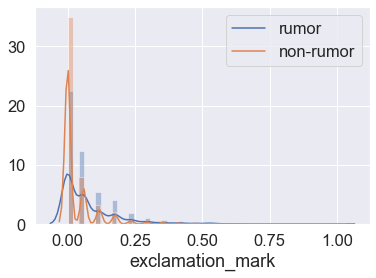

In [27]:
import seaborn as sns
sns.distplot(dataf[dataf.rumor=='rumor']['exclamation_mark'], kde_kws={'label':'rumor'})
sns.distplot(dataf[dataf.rumor=='non-rumor']['exclamation_mark'], kde_kws={'label':'non-rumor'})

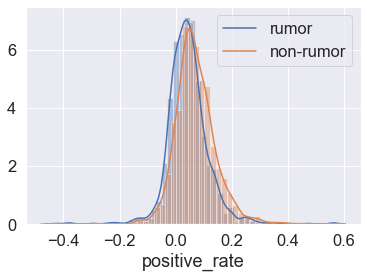

In [30]:
sns.distplot(dataf[dataf.rumor=='rumor']['positive_rate'], kde_kws={'label':'rumor'})
sns.distplot(dataf[dataf.rumor=='non-rumor']['positive_rate'], kde_kws={'label':'non-rumor'})

c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


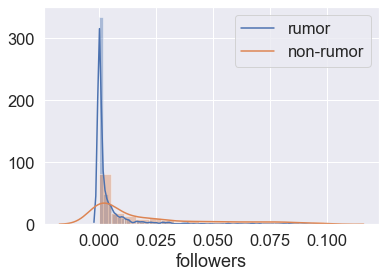

In [37]:
sns.distplot(dataf[dataf.rumor=='rumor'][dataf.followers<0.1]['followers'], kde_kws={'label':'rumor'})
sns.distplot(dataf[dataf.rumor=='non-rumor'][dataf.followers<0.1]['followers'], kde_kws={'label':'non-rumor'})

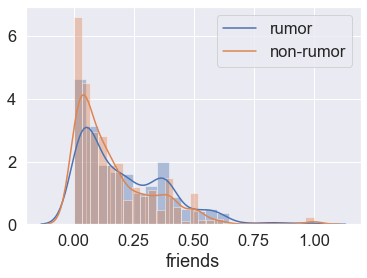

In [38]:
sns.distplot(dataf[dataf.rumor=='rumor']['friends'], kde_kws={'label':'rumor'})
sns.distplot(dataf[dataf.rumor=='non-rumor']['friends'], kde_kws={'label':'non-rumor'})

exclamation_mark    float64
question_mark       float64
friends             float64
followers           float64
positive_words      float64
negative_words      float64
positive_rate       float64
has_url             float64
description         float64
gender              float64
verified            float64
rumor                object
dtype: object


<Figure size 432x288 with 0 Axes>

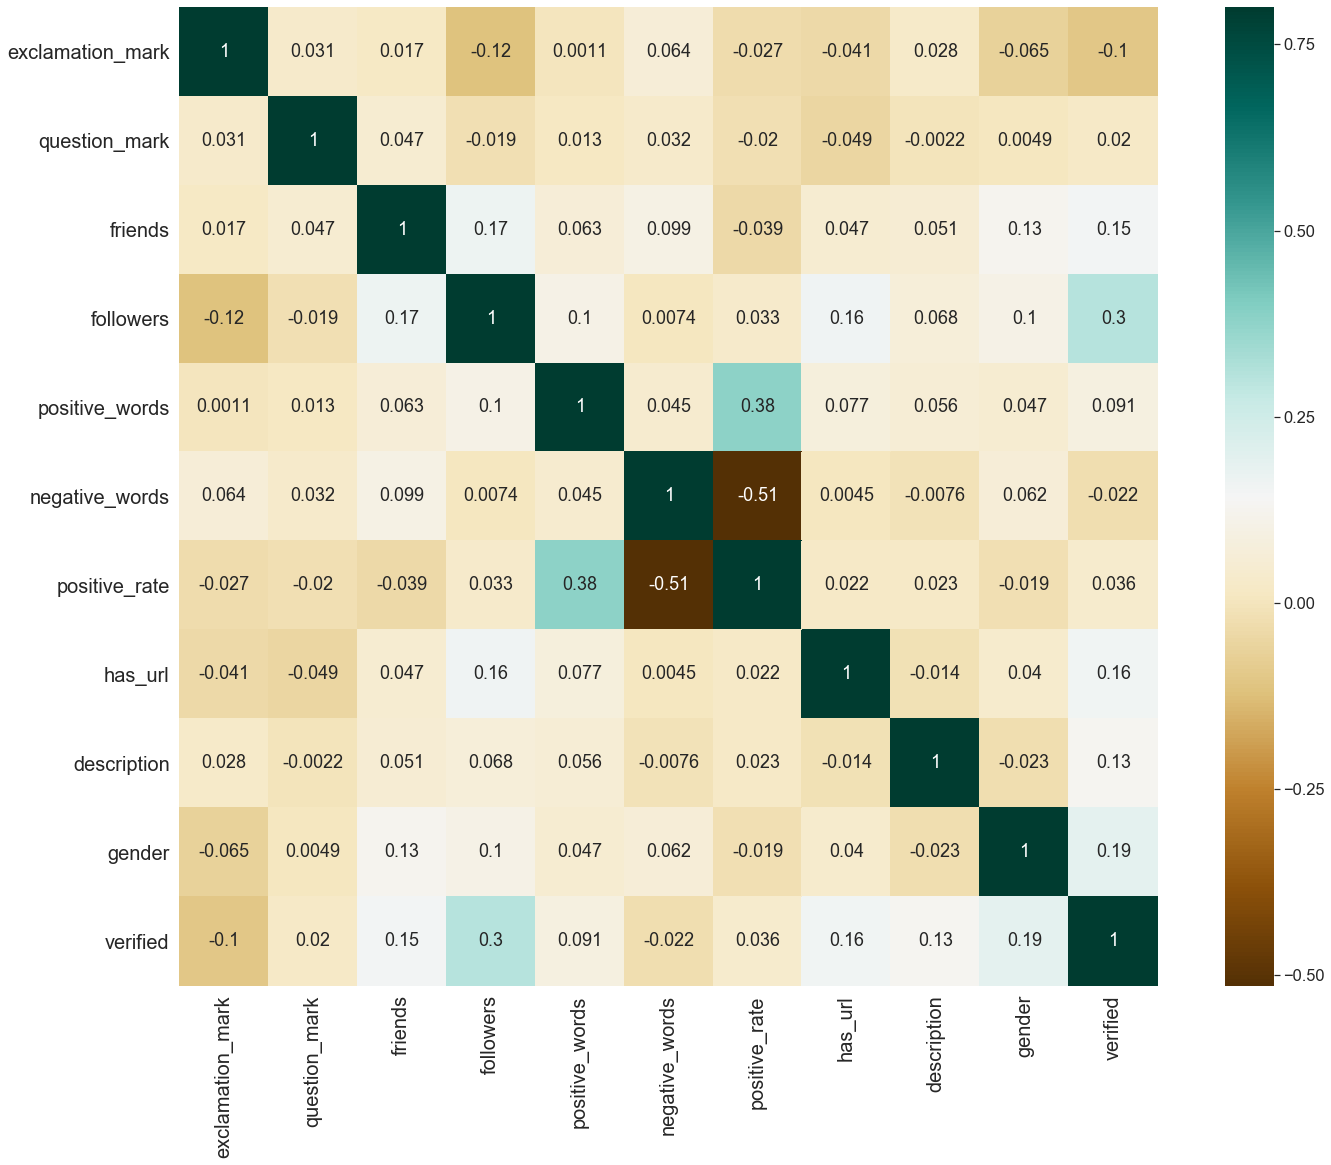

In [41]:
## 请保证本地matplotlib库的版本为3.1.2或以上或3.0.x以下，否则会出现最上面和最下面两行只显示一半的bug（不要问我为什么强调这个:)
import matplotlib.pyplot as plt
print(dataf.dtypes)
hmap = dataf.corr()
plt.figure()
plt.subplots(figsize=(24, 18))
sns.set(font_scale=1.5)
sns.heatmap(hmap, vmax=0.8, annot=True, cmap='BrBG', square=True)
plt.tick_params(labelsize=20)

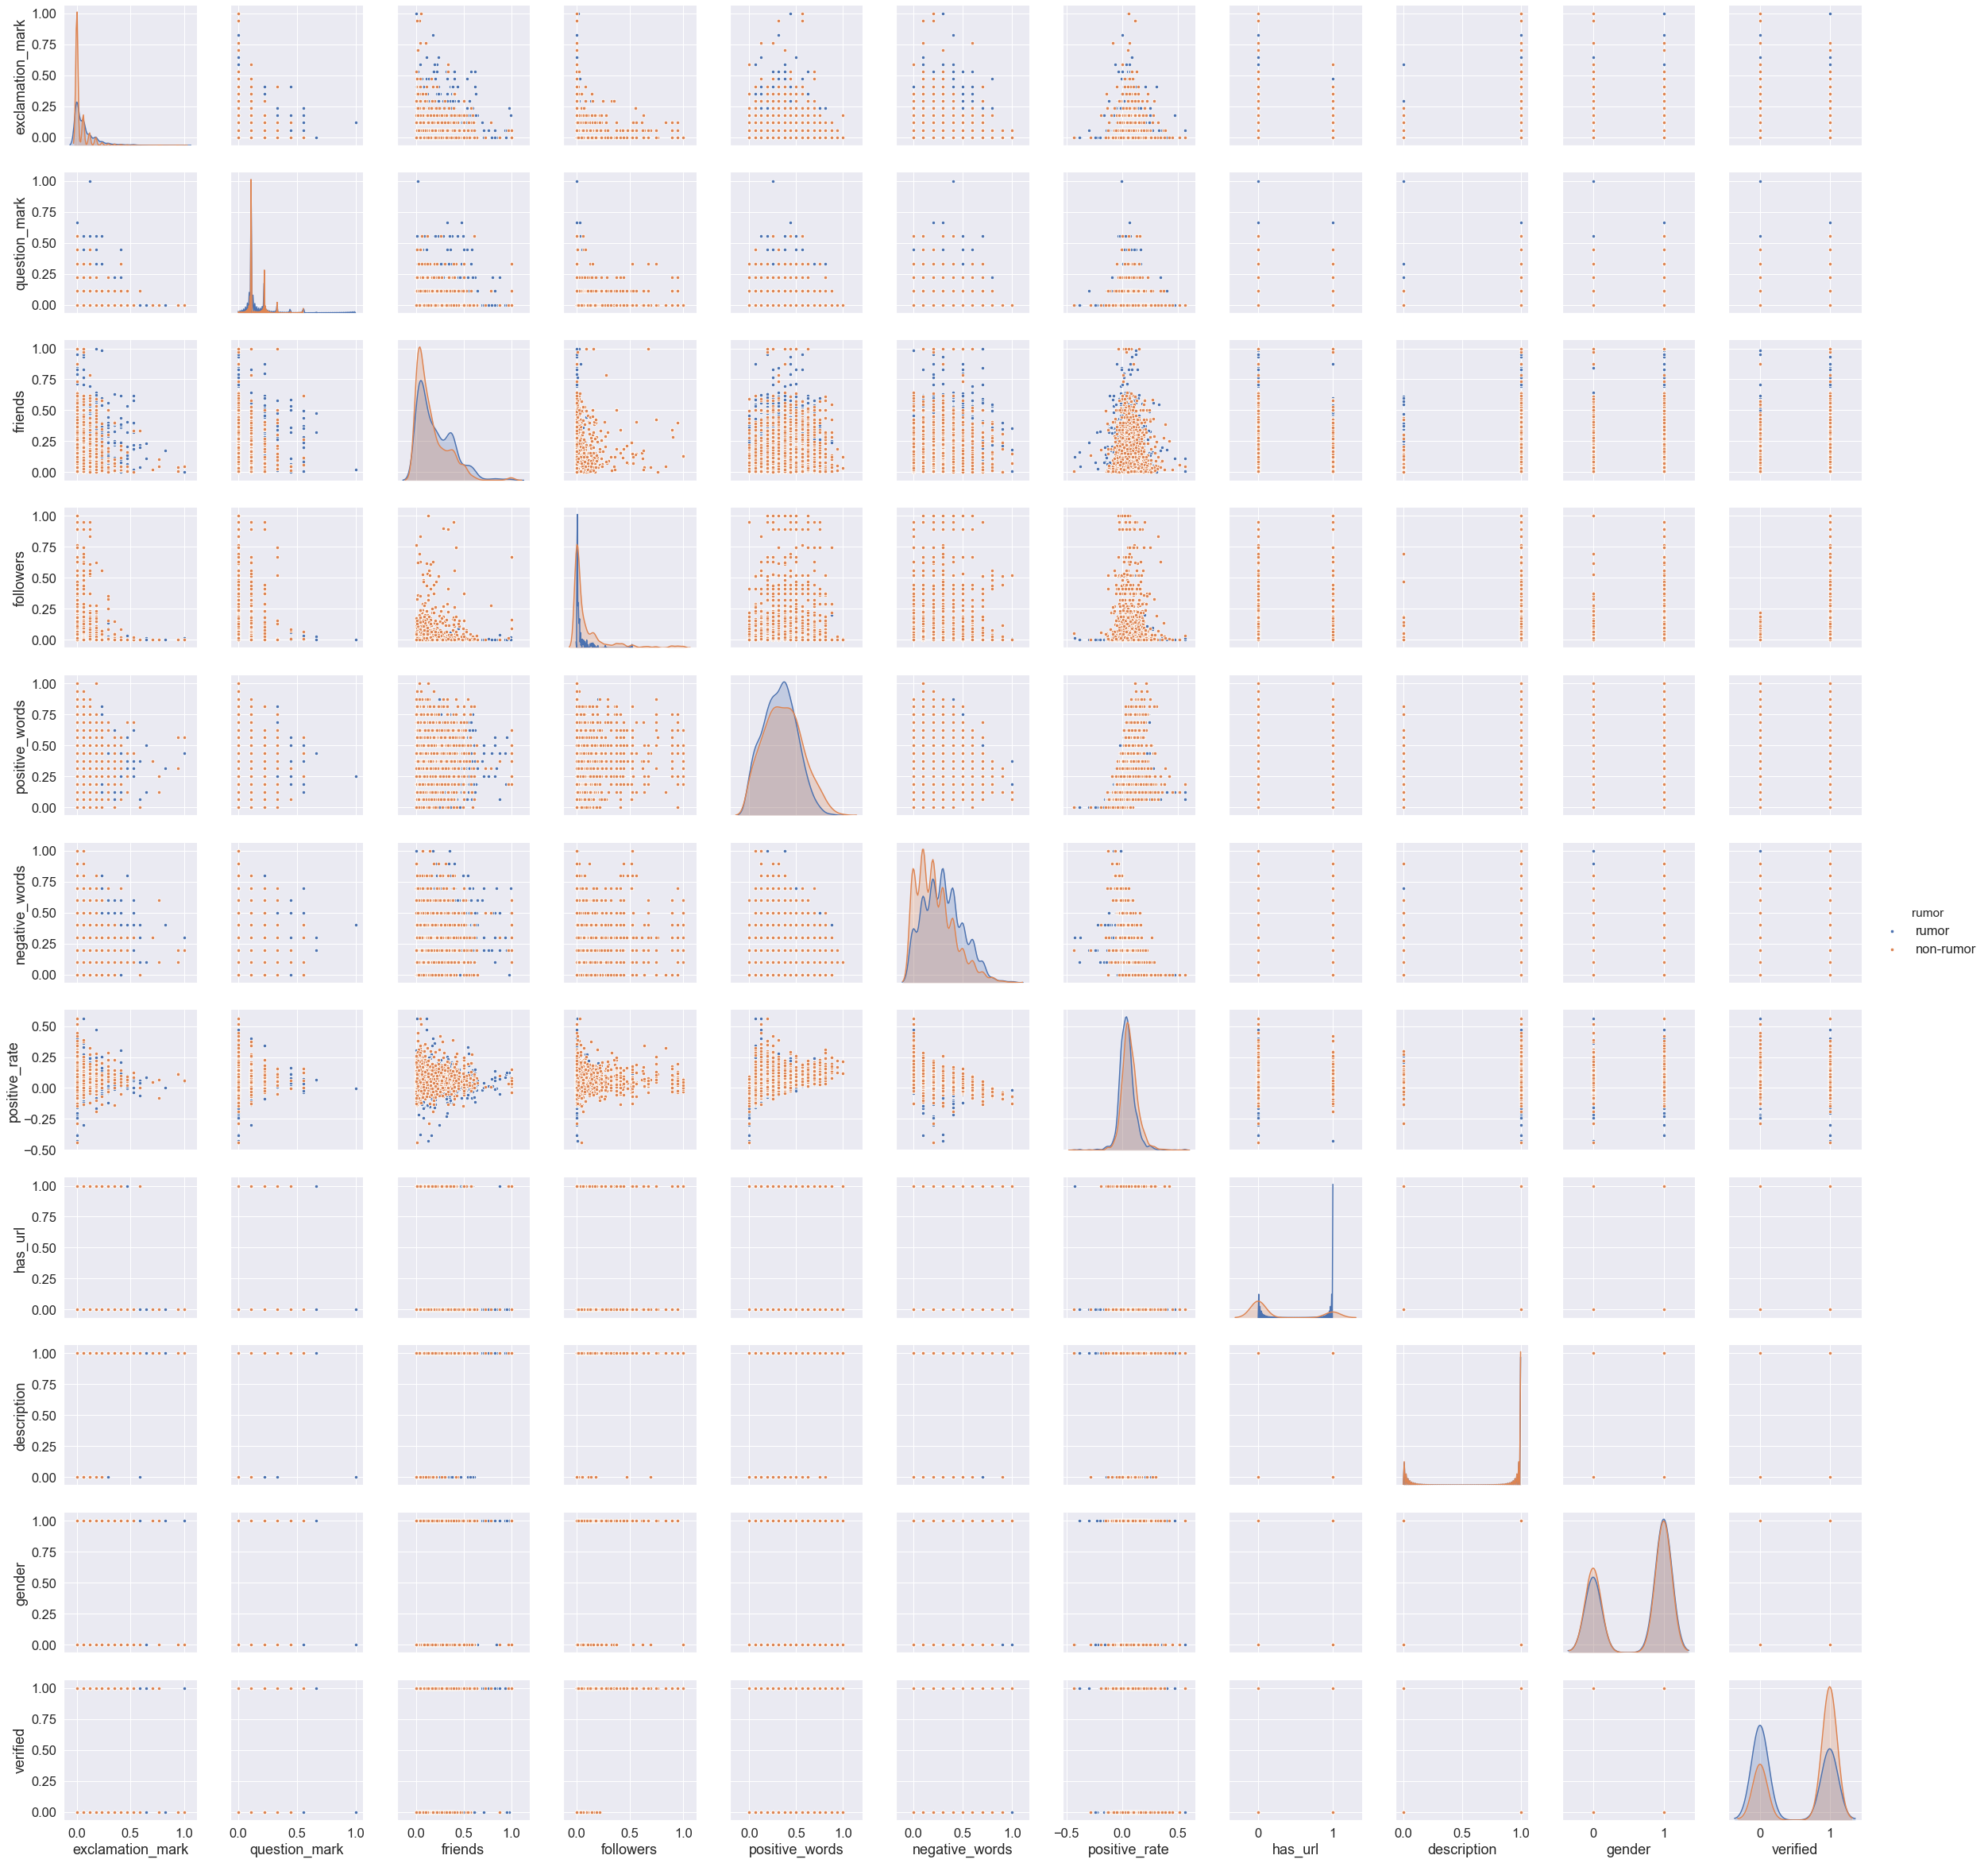

In [40]:
sns.pairplot(dataf, hue="rumor", palette='deep',
             size=3, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=20))

In [44]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
knn.fit(X_train, Y_train.ravel())

knn_pred = knn.predict(X_test)

print('The accuracy of the KNN is', metrics.accuracy_score(knn_pred, Y_test))

The accuracy of the KNN is 0.7131313131313132


In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1',max_iter=800,fit_intercept=False,solver='saga',C=20)
clf.fit(X_train, Y_train.ravel())
clf_pred = clf.predict(X_test)
print('The accuracy of the Logistic Regression is', metrics.accuracy_score(clf_pred, Y_test))

The accuracy of the Logistic Regression is 0.7686868686868686


In [46]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier(max_leaf_nodes=15, max_depth=30)
dtree = dtree.fit(X_train, Y_train.ravel())
dtree_pred = dtree.predict(X_test)
print('The accuracy of the Decision Tree is', metrics.accuracy_score(dtree_pred, Y_test))

The accuracy of the Decision Tree is 0.7454545454545455


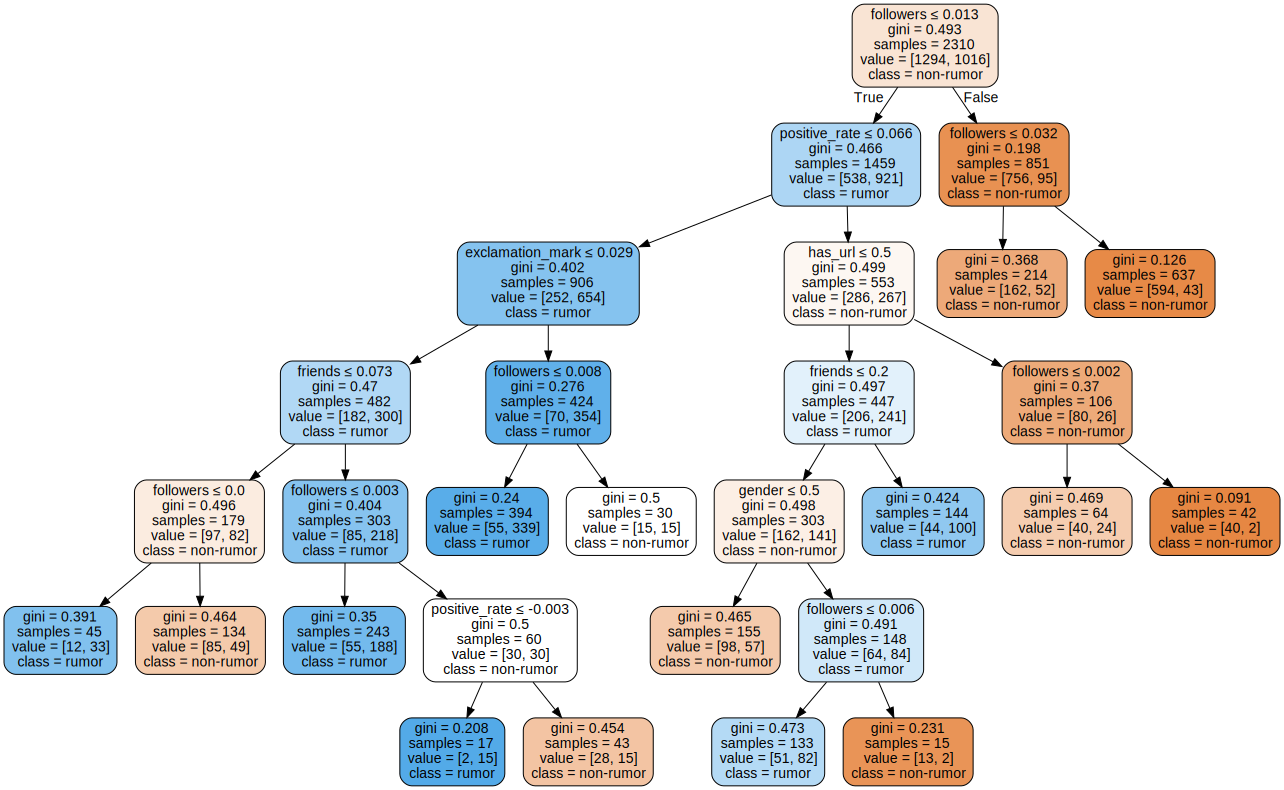

In [58]:
# visualize the decision tree
import graphviz

# feature_names=['exclamation_mark', 'question_mark', 'friends', 'followers', 'positive_words', 'negative_words', 'positive_rate', 'has_url', 'description', 'gender', 'verified']
# class_names=['non-rumor', 'rumor']
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=feature_names,class_names=class_names,
                                filled=True, rounded=True,special_characters=True)
graph1 = graphviz.Source(dot_data)

import pydotplus
graph2=pydotplus.graph_from_dot_data(dot_data)
graph2.write_pdf('2.pdf')

graph1


In [59]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    random_state = 0
)
rfc.fit(X_train, Y_train.ravel())
rfc_pred = rfc.predict(X_test)
print('The accuracy of the Random Forest is', metrics.accuracy_score(rfc_pred, Y_test))

The accuracy of the Random Forest is 0.7858585858585858


In [60]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators = 100,
    criterion ='entropy',
    random_state = 0
)
rfc.fit(X_train, Y_train.ravel())
rfc_pred = rfc.predict(X_test)
print('The accuracy of the Random Forest is', metrics.accuracy_score(rfc_pred, Y_test))

The accuracy of the Random Forest is 0.7717171717171717


In [61]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train, Y_train.ravel())
abc_pred = abc.predict(X_test)
print('The accuracy of the AdaBoost is', metrics.accuracy_score(abc_pred, Y_test))

The accuracy of the AdaBoost is 0.7696969696969697


可以看到，在学习模型中，表现最好的是RandomForest模型，下面进一步调参：

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(10, 120,10),'max_depth':np.arange(10,100,10),'max_leaf_nodes':np.arange(2,100,20)}

Rfc = RandomForestClassifier()
Rfc_cv = GridSearchCV(Rfc, param_grid, cv=3)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
Rfc_cv.fit(X_train, Y_train.ravel())

print(Rfc_cv.best_params_)
print(Rfc_cv.best_score_)

{'max_depth': 70, 'max_leaf_nodes': 82, 'n_estimators': 100}
0.79004329004329


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(60, 80, 5),'max_depth':np.arange(40,60,5),'max_leaf_nodes':np.arange(60,120,10)}

Rfc = RandomForestClassifier()
Rfc_cv = GridSearchCV(Rfc, param_grid, cv=3)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
Rfc_cv.fit(X_train, Y_train.ravel())

print(Rfc_cv.best_params_)
print(Rfc_cv.best_score_)

{'max_depth': 50, 'max_leaf_nodes': 100, 'n_estimators': 75}
0.7913419913419913


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(62, 68, 1),'max_depth':np.arange(46,52,1),'max_leaf_nodes':np.arange(90,100,1)}

Rfc = RandomForestClassifier()
Rfc_cv = GridSearchCV(Rfc, param_grid, cv=3)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
Rfc_cv.fit(X_train, Y_train.ravel())

print(Rfc_cv.best_params_)
print(Rfc_cv.best_score_)

{'max_depth': 51, 'max_leaf_nodes': 95, 'n_estimators': 63}
0.7909090909090909


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(30, 200, 10)}

Rfc = RandomForestClassifier()
Rfc_cv = GridSearchCV(Rfc, param_grid, cv=3)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
Rfc_cv.fit(conX, Y.ravel())

print(Rfc_cv.best_params_)
print(Rfc_cv.best_score_)

{'n_estimators': 170}
0.7842424242424242


In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(110, 130, 2)}

Rfc = RandomForestClassifier()
Rfc_cv = GridSearchCV(Rfc, param_grid, cv=3)

# change the shape of Y_train to (n_samples, ) using `.ravel()`
Rfc_cv.fit(X_train, Y_train.ravel())

print(Rfc_cv.best_params_)
print(Rfc_cv.best_score_)

{'n_estimators': 122}
0.7844155844155845


In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators = 118,
    criterion = 'gini',
    random_state = 0
)
rfc.fit(X_train, Y_train.ravel())
rfc_pred = rfc.predict(X_test)
print('The accuracy of the Random Forest is', metrics.accuracy_score(rfc_pred, Y_test))

The accuracy of the Random Forest is 0.7888888888888889


查看各特征的重要性：

In [63]:
rfcf=RandomForestClassifier(
    n_estimators=118,
    criterion = 'gini',
    random_state = 0
)
rfcf.fit(X_train, Y_train.ravel())
for j in zip(feature_names, rfcf.feature_importances_):
    print(j)

('exclamation_mark', 0.06132879347402999)
('question_mark', 0.023456691292703936)
('friends', 0.1518103983298208)
('followers', 0.3542632876955608)
('positive_words', 0.08046175973506683)
('negative_words', 0.07246633599533094)
('positive_rate', 0.15069153233769772)
('has_url', 0.026621527003040508)
('description', 0.008268131758053498)
('gender', 0.02351405594082627)
('verified', 0.04711748643786886)


其中依次对应：包含感叹号次数，包含问号次数，好友数，被关注量，正面词汇，负面词汇，正面率，是否包含链接，是否包含描述，性别，是否验证


[[446 109]
 [100 335]]
[[0.45050505 0.11010101]
 [0.1010101  0.33838384]]


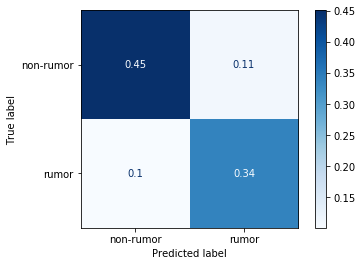

In [64]:
## Note that the version of scikit-learn must be at least 0.22
from sklearn import metrics
import matplotlib.pyplot as plt
print(metrics.confusion_matrix(Y_test ,rfc_pred))

disp = metrics.plot_confusion_matrix(rfc, X_test, Y_test, display_labels=class_names, normalize='all', cmap=plt.cm.Blues)

print(disp.confusion_matrix)

print(disp)

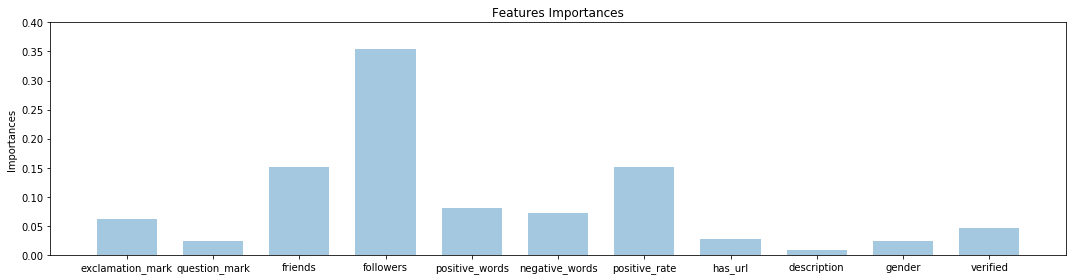

In [65]:
y_importances = rfc.feature_importances_
x_importances = feature_names
y_pos = np.arange(len(x_importances))
fig = plt.figure(figsize = (15,4))
plt.bar(y_pos, y_importances, width=0.7, align='center', alpha=0.4)
plt.xticks(y_pos, x_importances)
plt.ylabel('Importances')
plt.ylim(0,0.4)
plt.title('Features Importances')
plt.tight_layout()
plt.show()